In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate, RepeatedKFold, learning_curve
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, f1_score, roc_auc_score

In [8]:
labels_training = pd.read_csv('./../../labels/labels_v3/labels_v3_training_set.csv', index_col=0)
labels_test = pd.read_csv('./../../labels/labels_v3/labels_v3_test_set.csv', index_col=0)
features = pd.read_csv('./../../data_preprocessing/genetic_data_preprocessing/cleaned_Genomic_features_all_repositories.csv', index_col=0)

print(list(features))

['BRCA1/2_mut', 'other_HRR_gene_mutation_somatic', 'cnv_N_CNdipl', 'cnv_N_CNloss', 'cnv_N_CNgain', 'cnv_CNlt5_frac', 'cnv_CNgt10_frac', 'cnv_evenCN_frac', 'cnv_CNloss_frac', 'cnv_DUP_len_30000_inf', 'cnv_DUP_len_30_100', 'cnv_DEL_len_100000_inf', 'cnv_DIPLOID_len_100000_inf', 'sv_n_trans', 'sv_n_del', 'sv_n_inv', 'sv_n_tadem_dup', 'sv_trans_frac', 'sv_del_frac', 'sv_inv_frac', 'sv_tadem_dup_frac', 'sv_n_all_sv', 'sv_n_svclass_stdev', 'sv_dup_30000+', 'sv_del_100000+', 'sv_microhom_deletion_mean', 'sv_microhom_inversion_mean', 'sv_microhom_tandem-duplication_mean', 'sv_microhom_translocation_mean', 'indel_n_del', 'indel_n_ins', 'ins_indel_ratio', 'del_indel_ratio', 'indel_DEL_len_1', 'indel_DEL_len_2', 'indel_DEL_len_3', 'indel_DEL_len_4', 'indel_DEL_len_inf', 'indel_INS_len_1', 'indel_INS_len_2', 'indel_INS_len_3', 'indel_INS_len_4', 'indel_INS_len_inf', 'indel_DEL_mh', 'indel_DEL_noMHstatus', 'indel_DEL_rep', 'indel_del_mh_ratio', 'Telomeric_AI', 'Interstitial_AI', 'Telomeric_LOH', 'I

## Merge features and labels

In [9]:
labels_features_training = pd.merge(features, labels_training, on='SAMPLE_ID', how='inner')
labels_features_training

labels_features_test = pd.merge(features, labels_test, on='SAMPLE_ID', how='inner')
labels_features_test


labels_features_training = labels_features_training.set_index('SAMPLE_ID', inplace=False)
labels_features_test = labels_features_test.set_index('SAMPLE_ID', inplace=False)
labels_features_training.to_excel('merged_all_features_and_labels_v3_training_model_v6.0.xlsx')
labels_features_test.to_excel('merged_all_features_and_labels_v3_test_model_v6.0.xlsx')

## Sixth model run - labels v3, manually selected features

In [10]:
columns_to_drop = ['labels_v3']

# Training set definition

X_train = labels_features_training.drop(columns_to_drop, axis=1)
y_train = labels_features_training['labels_v3']


# Test set definition

X_test = labels_features_test.drop(columns_to_drop, axis=1)
y_test = labels_features_test['labels_v3']

original_training_indices = labels_features_training.index
original_test_indices = labels_features_test.index
X_train.index = original_training_indices
y_train.index = original_training_indices
X_test.index = original_test_indices
y_test.index = original_test_indices

### Features normalization

In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(127, 82)
(69, 82)


### Model training

In [12]:
model = LogisticRegression()
model.fit(X_train, y_train)

evaluation_criteria = {
    'roc_auc': 'roc_auc',
    'precision': 'precision',
    'average_precision': 'average_precision',
    'recall': 'recall',
    'f1': 'f1',
    'balanced_accuracy': 'balanced_accuracy',
    'positive_likelihood_ratio': 'positive_likelihood_ratio'
}

scores = cross_validate(model, X_train, y_train, cv=5, scoring=evaluation_criteria)

for metric in evaluation_criteria:
    print(f"{metric}: {scores['test_' + metric]}")
    print(f"Mean {metric}: {scores['test_' + metric].mean()}")
    print(f"Std {metric}: {scores['test_' + metric].std()}\n")

roc_auc: [0.79289941 0.70414201 0.75       0.83333333 0.73076923]
Mean roc_auc: 0.7622287968441814
Std roc_auc: 0.04584727664342406

precision: [0.69230769 0.58333333 0.77777778 0.6875     0.61538462]
Mean precision: 0.6712606837606837
Std precision: 0.06768446978278836

average_precision: [0.79150108 0.66046766 0.77987557 0.86911268 0.77248129]
Mean average_precision: 0.7746876550992334
Std average_precision: 0.06674843185577112

recall: [0.69230769 0.53846154 0.53846154 0.84615385 0.66666667]
Mean recall: 0.6564102564102564
Std recall: 0.1142105510324107

f1: [0.69230769 0.56       0.63636364 0.75862069 0.64      ]
Mean f1: 0.6574584036653003
Std f1: 0.06587291785949359

balanced_accuracy: [0.69230769 0.57692308 0.68589744 0.71474359 0.64102564]
Mean balanced_accuracy: 0.6621794871794872
Std balanced_accuracy: 0.0488863486280452

positive_likelihood_ratio: [2.25       1.4        3.23076923 2.03076923 1.73333333]
Mean positive_likelihood_ratio: 2.1289743589743586
Std positive_likeliho

### Model testing

In [13]:
y_pred = model.predict(X_test)

y_pred_list = pd.DataFrame(y_pred, columns=['Predicted'], index=original_test_indices)

## Model evaluation

In [14]:
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"AUC: {roc_auc}")
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(cr)

Accuracy: 0.6376811594202898
AUC: 0.4974576271186441
Confusion Matrix:
[[ 3  7]
 [18 41]]
Classification Report:
              precision    recall  f1-score   support

           0       0.14      0.30      0.19        10
           1       0.85      0.69      0.77        59

    accuracy                           0.64        69
   macro avg       0.50      0.50      0.48        69
weighted avg       0.75      0.64      0.68        69



<Axes: >

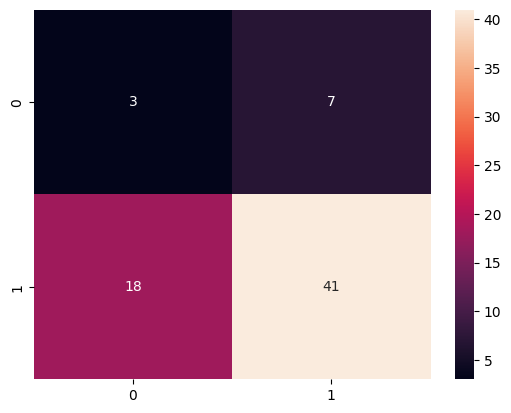

In [15]:
import seaborn as sns
sns.heatmap(cm, annot=True)

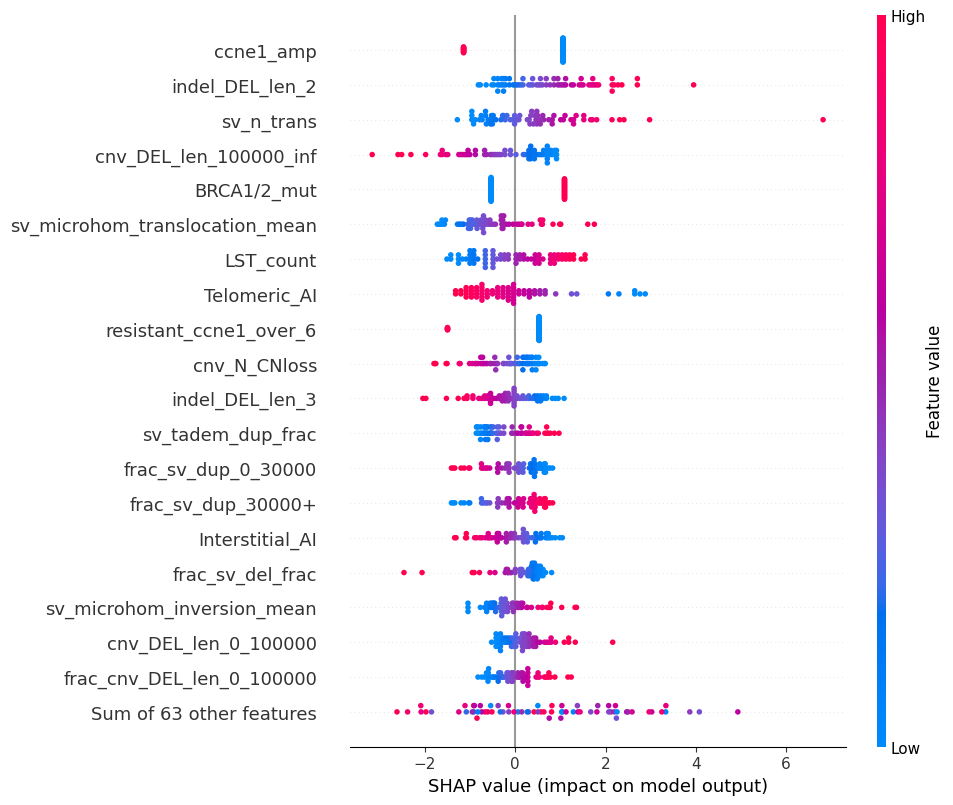

In [16]:
import shap

original_feature_names = ['BRCA1/2_mut', 'other_HRR_gene_mutation_somatic', 'cnv_N_CNdipl', 'cnv_N_CNloss', 'cnv_N_CNgain', 'cnv_CNlt5_frac', 'cnv_CNgt10_frac', 'cnv_evenCN_frac', 'cnv_CNloss_frac', 'cnv_DUP_len_30000_inf', 'cnv_DUP_len_30_100', 'cnv_DEL_len_100000_inf', 'cnv_DIPLOID_len_100000_inf', 'sv_n_trans', 'sv_n_del', 'sv_n_inv', 'sv_n_tadem_dup', 'sv_trans_frac', 'sv_del_frac', 'sv_inv_frac', 'sv_tadem_dup_frac', 'sv_n_all_sv', 'sv_n_svclass_stdev', 'sv_dup_30000+', 'sv_del_100000+', 'sv_microhom_deletion_mean', 'sv_microhom_inversion_mean', 'sv_microhom_tandem-duplication_mean', 'sv_microhom_translocation_mean', 'indel_n_del', 'indel_n_ins', 'ins_indel_ratio', 'del_indel_ratio', 'indel_DEL_len_1', 'indel_DEL_len_2', 'indel_DEL_len_3', 'indel_DEL_len_4', 'indel_DEL_len_inf', 'indel_INS_len_1', 'indel_INS_len_2', 'indel_INS_len_3', 'indel_INS_len_4', 'indel_INS_len_inf', 'indel_DEL_mh', 'indel_DEL_noMHstatus', 'indel_DEL_rep', 'indel_del_mh_ratio', 'Telomeric_AI', 'Interstitial_AI', 'Telomeric_LOH', 'Interstitial_LOH', 'Ploidy', 'aberrant_cell_fraction', 'LST_count', 'LOH_count', 'MSI', 'cnv_DEL_0_3500_sum_indel_DEL_len_inf', 'indel_INS_len_inf_sum_cnv_DUP_0_30000', 'indel_INS_len_inf_sum_cnv_DUP_0_1000', 'frac_cnv_DUP_len_30000_inf', 'frac_cnv_DEL_len_100000_inf', 'frac_cnv_DIPLOID_len_100000_inf', 'frac_sv_dup_30000+', 'frac_sv_del_frac', 'frac_sv_del_100000+', 'FBI_relaxed', 'percent_all_cc2ca', 'percent_all_cc2ct', 'cc2ca_vs_cc2ct', 'SBS31', 'ccne1_amp', 'resistant_ccne1_over_6', 'cnv_DUP_len_0_30000', 'cnv_DEL_len_0_100000', 'cnv_DIPLOID_len_0_100000', 'sv_dup_0_30000', 'sv_del_0_100000', 'frac_cnv_DUP_len_0_30000', 'frac_cnv_DEL_len_0_100000', 'frac_cnv_DIPLOID_len_0_100000', 'frac_sv_dup_0_30000', 'frac_sv_del_0_100000']
X_train_features = pd.DataFrame(X_train, columns=original_feature_names)
X_test_features = pd.DataFrame(X_test, columns=original_feature_names)

explainer = shap.Explainer(model, X_train_features)
shap_values = explainer(X_test_features)
shap.plots.beeswarm(shap_values, max_display=20)

In [18]:
predicted_vs_original_labels = pd.merge(labels_test, y_pred_list, on='SAMPLE_ID', how='inner')
predicted_vs_original_labels.to_csv('predicted_vs_original_labels_model_v6.0.csv')